# **Road Vehicle Accident Severity Prediction in Seattle, WA**
---

### Applied Data Science Capstone - IBM/Coursera

### Table of contents

* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

The objective of this project is to predict the severity of a road accident using machine learning models.

These models can be used to explain important factors that influence the severity of the accident. This can be useful for the main target of this project: policymakers aiming at the reduction of the impact caused by these accidents.

The first thing to do is import all the libraries we will use:

In [1]:
from IPython import display

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import geocoder
import folium
import folium.plugins

from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from joblib import dump, load

In [2]:
import shap
shap.initjs()

## Data <a name="data"></a>

To try to answer the question, we will use open data from the city of Seattle, which can be dowloaded in the following links:
* [Dataset](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv)
* [Metadata](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf)

### Car accidents data

In [3]:
df = pd.read_csv('./data/seattle/Data-Collisions.csv', low_memory=False)

In [4]:
print(df.shape)
with pd.option_context('display.max_columns', None):
    display.display(df.head())

(194673, 38)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,5TH AVE NE AND NE 103RD ST,,NaN,2,Injury Collision,Angles,2,0,0,2,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Overcast,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,NaN,NaN,1,Property Damage Only Collision,Parked Car,4,0,0,3,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,2ND AVE BETWEEN MARION ST AND MADISON ST,,NaN,1,Property Damage Only Collision,Other,3,0,0,3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,SWIFT AVE S AND SWIFT AV OFF RP,NaN,NaN,2,Injury Collision,Angles,2,0,0,2,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


After loading the data we already see some missing values in the first 5 rows. We will address this problem before doing any analysis and modeling.

In [5]:
round(df.isnull().sum() / df.shape[0] * 100, 2)

SEVERITYCODE       0.00
X                  2.74
Y                  2.74
OBJECTID           0.00
INCKEY             0.00
COLDETKEY          0.00
REPORTNO           0.00
STATUS             0.00
ADDRTYPE           0.99
INTKEY            66.57
LOCATION           1.38
EXCEPTRSNCODE     56.43
EXCEPTRSNDESC     97.10
SEVERITYCODE.1     0.00
SEVERITYDESC       0.00
COLLISIONTYPE      2.52
PERSONCOUNT        0.00
PEDCOUNT           0.00
PEDCYLCOUNT        0.00
VEHCOUNT           0.00
INCDATE            0.00
INCDTTM            0.00
JUNCTIONTYPE       3.25
SDOT_COLCODE       0.00
SDOT_COLDESC       0.00
INATTENTIONIND    84.69
UNDERINFL          2.51
WEATHER            2.61
ROADCOND           2.57
LIGHTCOND          2.66
PEDROWNOTGRNT     97.60
SDOTCOLNUM        40.96
SPEEDING          95.21
ST_COLCODE         0.01
ST_COLDESC         2.52
SEGLANEKEY         0.00
CROSSWALKKEY       0.00
HITPARKEDCAR       0.00
dtype: float64

Some columns have a lot of missing values. This means they won't be useful for our analysis and prediction, and will be removed together with columns that have little value for us, such as ID's or redundant information.

We are also removing all accidents that are missing the location.

In [6]:
df_clean = df

# remove all accidents wihtout location
df_clean = df_clean.loc[~(df.X.isna() | df.Y.isna())].reset_index(drop=True).copy()

In [7]:
df_clean.drop(columns=['INTKEY',
                       'INCKEY',
                       'LOCATION',
                       'STATUS',
                       'REPORTNO',
                       'COLDETKEY',
                       'OBJECTID',
                       'EXCEPTRSNCODE',
                       'EXCEPTRSNDESC',
                       'INATTENTIONIND',
                       'PEDROWNOTGRNT',
                       'SDOTCOLNUM',
                       'INCDATE',
                       'SPEEDING',
                       'SEVERITYCODE.1'], inplace=True)

In [8]:
# dropping description columns because they are redundant with code columns,
# location because is redundant with latitude and longitude values,
df_clean = df_clean.loc[:, ~df_clean.columns.str.contains('DESC')]
df_clean.shape

(189339, 20)

We need to check the categorical columns for wrong values and fix them before imputing them.

In [9]:
df_clean.loc[:, df_clean.dtypes.eq(np.object)].head()

,ADDRTYPE,COLLISIONTYPE,INCDTTM,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,ST_COLCODE,HITPARKEDCAR
0,Intersection,Angles,3/27/2013 2:54:00 PM,At Intersection (intersection related),N,Overcast,Wet,Daylight,10,N
1,Block,Sideswipe,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),0,Raining,Wet,Dark - Street Lights On,11,N
2,Block,Parked Car,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),0,Overcast,Dry,Daylight,32,N
3,Block,Other,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),N,Clear,Dry,Daylight,23,N
4,Intersection,Angles,1/28/2004 8:04:00 AM,At Intersection (intersection related),0,Raining,Wet,Daylight,10,N


In [10]:
for col in df_clean.loc[:, df_clean.dtypes.eq(np.object)].columns:
    print(f'{col}: {df_clean[col].unique()}\n')

ADDRTYPE: ['Intersection' 'Block']

COLLISIONTYPE: ['Angles' 'Sideswipe' 'Parked Car' 'Other' 'Cycles' 'Rear Ended' 'Head On'
 nan 'Left Turn' 'Pedestrian' 'Right Turn']

INCDTTM: ['3/27/2013 2:54:00 PM' '12/20/2006 6:55:00 PM' '11/18/2004 10:20:00 AM'
 ... '1/19/2019 9:25:00 AM' '1/15/2019 4:48:00 PM' '11/30/2018 3:45:00 PM']

JUNCTIONTYPE: ['At Intersection (intersection related)'
 'Mid-Block (not related to intersection)' 'Driveway Junction'
 'At Intersection (but not related to intersection)'
 'Mid-Block (but intersection related)' nan 'Ramp Junction' 'Unknown']

UNDERINFL: ['N' '0' nan '1' 'Y']

WEATHER: ['Overcast' 'Raining' 'Clear' nan 'Unknown' 'Other' 'Snowing'
 'Fog/Smog/Smoke' 'Sleet/Hail/Freezing Rain' 'Blowing Sand/Dirt'
 'Severe Crosswind' 'Partly Cloudy']

ROADCOND: ['Wet' 'Dry' nan 'Unknown' 'Snow/Slush' 'Ice' 'Other' 'Sand/Mud/Dirt'
 'Standing Water' 'Oil']

LIGHTCOND: ['Daylight' 'Dark - Street Lights On' 'Dark - No Street Lights' nan
 'Unknown' 'Dusk' 'Dawn' 'Dark - 

`INCDTTM` should be of type datetime.

In [11]:
df_clean['INCDTTM'] = pd.to_datetime(df_clean['INCDTTM'])

Converting unknown values to `np.nan`

In [12]:
df_clean.loc[df_clean['JUNCTIONTYPE'].eq('Unknown'), 'JUNCTIONTYPE'] = np.nan
df_clean.loc[df_clean['WEATHER'].eq('Unknown'), 'WEATHER'] = np.nan
df_clean.loc[df_clean['ROADCOND'].eq('Unknown'), 'ROADCOND'] = np.nan
df_clean.loc[df_clean['LIGHTCOND'].eq('Unknown'), 'LIGHTCOND'] = np.nan
df_clean.loc[df_clean['ST_COLCODE'].eq(' '), 'ST_COLCODE'] = np.nan

`UNDERINFL` has multiple labels for the same value.

In [13]:
df_clean['UNDERINFL'].unique()

array(['N', '0', nan, '1', 'Y'], dtype=object)

In [14]:
df_clean['UNDERINFL'] = df_clean['UNDERINFL'].map({'0': 'N', '1': 'Y', 'N': 'N', 'Y': 'Y'})

In [15]:
round(df_clean.isnull().sum() / df_clean.shape[0] * 100, 2)

SEVERITYCODE     0.00
X                0.00
Y                0.00
ADDRTYPE         0.00
COLLISIONTYPE    2.51
PERSONCOUNT      0.00
PEDCOUNT         0.00
PEDCYLCOUNT      0.00
VEHCOUNT         0.00
INCDTTM          0.00
JUNCTIONTYPE     2.22
SDOT_COLCODE     0.00
UNDERINFL        2.50
WEATHER          9.94
ROADCOND         9.87
LIGHTCOND        9.21
ST_COLCODE       2.51
SEGLANEKEY       0.00
CROSSWALKKEY     0.00
HITPARKEDCAR     0.00
dtype: float64

We can see that the number of missing values increased to almost 10% in columns of conditions of weather, road and light.

Let's see the columns which have missing values:

In [16]:
missing_columns = df_clean.loc[:, df_clean.isna().any()].columns
df_clean[missing_columns].head()

,COLLISIONTYPE,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,ST_COLCODE
0,Angles,At Intersection (intersection related),N,Overcast,Wet,Daylight,10
1,Sideswipe,Mid-Block (not related to intersection),N,Raining,Wet,Dark - Street Lights On,11
2,Parked Car,Mid-Block (not related to intersection),N,Overcast,Dry,Daylight,32
3,Other,Mid-Block (not related to intersection),N,Clear,Dry,Daylight,23
4,Angles,At Intersection (intersection related),N,Raining,Wet,Daylight,10


Now we can impute the values using the most common value.

In [17]:
for col in missing_columns:
    imp = SimpleImputer(missing_values = np.nan, strategy='constant', fill_value=df_clean[col].mode())
    df_clean[col] = imp.fit_transform(df_clean[col].to_numpy().reshape(-1, 1))

In [18]:
df_clean.isna().sum().sum()

0

And fix the type of columns which had missing values:

In [19]:
df_clean['ST_COLCODE'] = df_clean['ST_COLCODE'].astype(int)

We will also check for categories with low variance and join them into 'Other':

In [20]:
for i in df_clean.loc[:, df_clean.dtypes.eq(np.object)].columns:
    print(df_clean[i].value_counts(), '\n')

Block           124591
Intersection     64748
Name: ADDRTYPE, dtype: int64 

Parked Car    51138
Angles        34460
Rear Ended    32968
Other         22277
Sideswipe     18034
Left Turn     13624
Pedestrian     6551
Cycles         5378
Right Turn     2912
Head On        1997
Name: COLLISIONTYPE, dtype: int64 

Mid-Block (not related to intersection)              91589
At Intersection (intersection related)               62491
Mid-Block (but intersection related)                 22465
Driveway Junction                                    10580
At Intersection (but not related to intersection)     2071
Ramp Junction                                          143
Name: JUNCTIONTYPE, dtype: int64 

N    180458
Y      8881
Name: UNDERINFL, dtype: int64 

Clear                       127777
Raining                      32015
Overcast                     27136
Snowing                        894
Other                          773
Fog/Smog/Smoke                 553
Sleet/Hail/Freezing Rain       1

In [21]:
weather_lowfreq = ['Partly Cloudy',
                   'Severe Crosswind',
                   'Blowing Sand/Dirt',
                   'Sleet/Hail/Freezing Rain',
                   'Fog/Smog/Smoke']

df_clean['WEATHER'] = df_clean['WEATHER'].apply(lambda x: 'Other' if x in weather_lowfreq else x)

In [22]:
road_lowfreq = ['Standing Water', 'Sand/Mud/Dirt', 'Oil']

df_clean['ROADCOND'] = df_clean['ROADCOND'].apply(lambda x: 'Other' if x in road_lowfreq else x)

In [23]:
light_lowfreq = ['Dark - Unknown Lighting']

df_clean['LIGHTCOND'] = df_clean['LIGHTCOND'].apply(lambda x: 'Other' if x in light_lowfreq else x)

### Feature Engineering

In [24]:
X = df_clean.drop(columns=['SEVERITYCODE'])
y = df_clean['SEVERITYCODE']

For this data to be input in the models, we need to transform these object columns into numbers using some form of encoding.

In [25]:
X.loc[:, X.dtypes.eq(np.object)].head(1)

,ADDRTYPE,COLLISIONTYPE,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,HITPARKEDCAR
0,Intersection,Angles,At Intersection (intersection related),N,Overcast,Wet,Daylight,N


Columns with only two values will be converted to 0's and 1's. The others will be one-hot encoded.

In [26]:
for col in X.loc[:, X.dtypes.eq(np.object)].columns:
    print(f'{col}: {X[col].nunique()}')

ADDRTYPE: 2
COLLISIONTYPE: 10
JUNCTIONTYPE: 6
UNDERINFL: 2
WEATHER: 5
ROADCOND: 5
LIGHTCOND: 7
HITPARKEDCAR: 2


Let's print the `ADDRTYPE` column so we can verify that the encoding is correct

In [27]:
X['ADDRTYPE'].head()

0    Intersection
1           Block
2           Block
3           Block
4    Intersection
Name: ADDRTYPE, dtype: object

Encode the columns using pandas `factorize`

In [28]:
labels = {}

for col in ['ADDRTYPE', 'UNDERINFL', 'HITPARKEDCAR']:
    X[col], labels[col] = X[col].factorize(sort=True)

for i in labels:
    labels[i] = dict(enumerate(labels[i]))

In [29]:
X['ADDRTYPE'].head()

0    1
1    0
2    0
3    0
4    1
Name: ADDRTYPE, dtype: int64

With the labels saved in a dictionary, we can convert the columns back to strings easily:

In [30]:
labels['ADDRTYPE']

{0: 'Block', 1: 'Intersection'}

In [31]:
X['ADDRTYPE'].map(labels['ADDRTYPE']).head()

0    Intersection
1           Block
2           Block
3           Block
4    Intersection
Name: ADDRTYPE, dtype: object

Now one-hot encode the remaining categorical variables:

In [32]:
categorical = X.loc[:, X.dtypes.eq(np.object)].columns.values
categorical

array(['COLLISIONTYPE', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND',
       'LIGHTCOND'], dtype=object)

In [33]:
X = X.join(pd.get_dummies(X[categorical], prefix=['CT', 'JT', 'W', 'R', 'L']))
X.drop(columns=categorical, inplace=True)

As the time and date features are cyclical, they need a special type of encoding to serve as input for the models.

Sinusoidal encoding makes possible to represent date and time in a format that can be given to models, while keeping the cyclical properties. If you want to know more about click [here](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/).

In [34]:
#X['YEAR'] = X['INCDTTM'].apply(lambda x: x.year)
#X['MONTH'] = X['INCDTTM'].apply(lambda x: x.month)
#X['DAY'] = X['INCDTTM'].apply(lambda x: x.day)
X['DAY_OF_WEEK'] = X['INCDTTM'].apply(lambda x: x.dayofweek + 1)
#X['HOUR'] = X['INCDTTM'].apply(lambda x: x.hour)
#X['MINUTE'] = X['INCDTTM'].apply(lambda x: x.minute)

In [35]:
X.drop(columns=['INCDTTM'], inplace=True)

In [36]:
#months_in_year = 12
#days_in_month = 30
#hours_in_day = 24
#X['SIN_MONTH'] = np.sin(2 * np.pi * X['MONTH'] / months_in_year)
#X['COS_MONTH'] = np.cos(2 * np.pi * X['MONTH'] / months_in_year)
#X['SIN_DAY'] = np.sin(2 * np.pi * X['DAY'] / days_in_month)
#X['COS_DAY'] = np.cos(2 * np.pi * X['DAY'] / days_in_month)
#X['SIN_HOUR'] = np.sin(2 * np.pi * X['HOUR'] / hours_in_day)
#X['COS_HOUR'] = np.cos(2 * np.pi * X['HOUR'] / hours_in_day)

# we are going to use only weekday for the models
days_in_week = 7
X['SIN_DOW'] = np.sin(2 * np.pi * X['DAY_OF_WEEK'] / days_in_week)
X['COS_DOW'] = np.cos(2 * np.pi * X['DAY_OF_WEEK'] / days_in_week)

X.drop(columns=['DAY_OF_WEEK'], inplace=True)

Removing latitude and longitude values didn't have a negative impact on the models. It is better to drop these columns so the model can better generalize to other places/cities.

In [37]:
X.drop(columns=['X', 'Y', 'CROSSWALKKEY', 'SEGLANEKEY'], inplace=True)

This is the final input for the models:

In [38]:
print(X.shape)
with pd.option_context('display.max_columns', None):
    display.display(X.head())

(189339, 44)


,ADDRTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,SDOT_COLCODE,UNDERINFL,ST_COLCODE,HITPARKEDCAR,CT_Angles,CT_Cycles,CT_Head On,CT_Left Turn,CT_Other,CT_Parked Car,CT_Pedestrian,CT_Rear Ended,CT_Right Turn,CT_Sideswipe,JT_At Intersection (but not related to intersection),JT_At Intersection (intersection related),JT_Driveway Junction,JT_Mid-Block (but intersection related),JT_Mid-Block (not related to intersection),JT_Ramp Junction,W_Clear,W_Other,W_Overcast,W_Raining,W_Snowing,R_Dry,R_Ice,R_Other,R_Snow/Slush,R_Wet,L_Dark - No Street Lights,L_Dark - Street Lights Off,L_Dark - Street Lights On,L_Dawn,L_Daylight,L_Dusk,L_Other,SIN_DOW,COS_DOW
0,1,2,0,0,2,11,0,10,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.433884,-0.900969
1,0,2,0,0,2,16,0,11,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0.433884,-0.900969
2,0,4,0,0,3,14,0,32,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,-0.433884,-0.900969
3,0,3,0,0,3,11,0,23,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,-0.974928,-0.222521
4,1,2,0,0,2,11,0,10,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0.433884,-0.900969


## Methodology <a name="methodology"></a>

### Exploratory Data Analysis (EDA)

The first important thing to verify is class imbalance.

In [39]:
print(df_clean['SEVERITYCODE'].map({1: 'Property Damage Only', 2: 'Injury'}).value_counts())

Property Damage Only    132221
Injury                   57118
Name: SEVERITYCODE, dtype: int64


In [40]:
print(df_clean['SEVERITYCODE'].map({1: 'Property Damage Only', 2: 'Injury'}).value_counts(normalize=True))

Property Damage Only    0.698329
Injury                  0.301671
Name: SEVERITYCODE, dtype: float64


In our case approximately 70% of the cases are of low severity, and only 30% of high severity, but as we have much data, we will simply use the random undersampling technique.

An interesting thing to see is the evolution of the accidents in relation to time.

In [41]:
print(df_clean['INCDTTM'].min())
print(df_clean['INCDTTM'].max())

2004-01-01 00:00:00
2020-05-20 00:00:00


We got data since 2004 until may 2020. For plotting graphs in the EDA we will remove the year of 2020 because it has incomplete data.

In [42]:
not2020 = ~df_clean['INCDTTM'].astype('string').str.contains('2020')
df_plotting = df_clean['INCDTTM'][not2020].sort_values()

def sel_year(year):
    return df_clean['INCDTTM'].astype('string').str.contains(f'{year}')

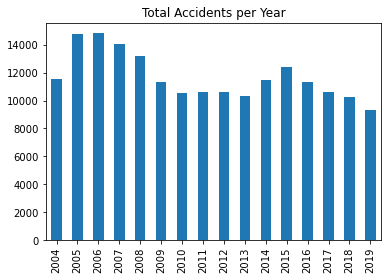

In [43]:
df_plotting.dt.year.value_counts(sort=False).plot.bar()
plt.title('Total Accidents per Year')
plt.show()

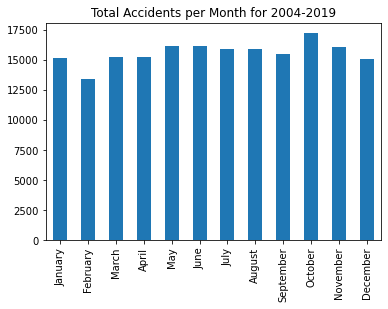

In [44]:
months_plt = df_plotting.dt.month.value_counts(sort=False)
months_plt.index = months_plt.index.map({
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
})
months_plt.plot.bar()
plt.title('Total Accidents per Month for 2004-2019')
plt.show()

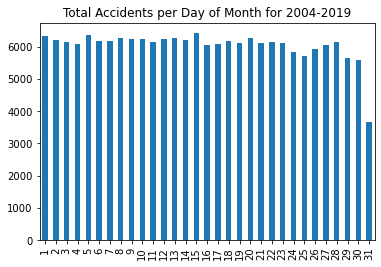

In [45]:
df_clean['INCDTTM'][not2020].dt.day.value_counts(sort=False).plot.bar()
plt.title('Total Accidents per Day of Month for 2004-2019')
plt.show()

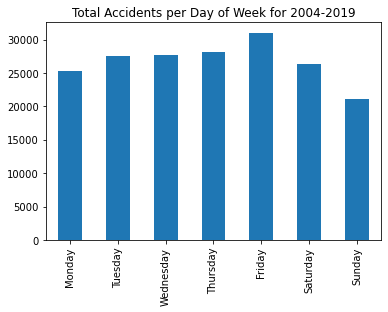

In [46]:
weekdays = df_clean['INCDTTM'][not2020].dt.weekday.value_counts(sort=False)
weekdays.index = weekdays.index.map({0: 'Monday',
                                     1: 'Tuesday',
                                     2: 'Wednesday',
                                     3: 'Thursday',
                                     4: 'Friday',
                                     5: 'Saturday',
                                     6: 'Sunday'})
ax = weekdays.plot.bar()
plt.title('Total Accidents per Day of Week for 2004-2019')
plt.show()

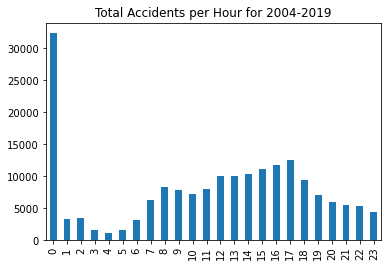

In [47]:
df_clean['INCDTTM'][not2020].dt.hour.value_counts(sort=False).sort_index().plot.bar()
plt.title('Total Accidents per Hour for 2004-2019')
plt.show()

In [48]:
pd.crosstab(y, df_clean['ADDRTYPE'], normalize='columns')

ADDRTYPE,Block,Intersection
SEVERITYCODE,,
1,0.764028,0.57191
2,0.235972,0.42809


(0.0, 1.0)

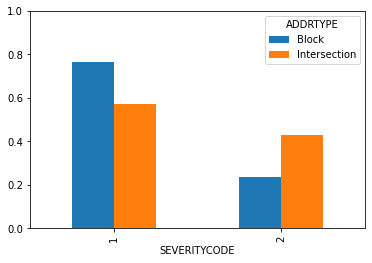

In [49]:
pd.crosstab(y, df_clean['ADDRTYPE'], normalize='columns').plot.bar()
plt.ylim(0, 1)

In [50]:
pd.crosstab(y, df_clean['UNDERINFL'], normalize='columns')

UNDERINFL,N,Y
SEVERITYCODE,,
1,0.70279,0.607702
2,0.29721,0.392298


(0.0, 1.0)

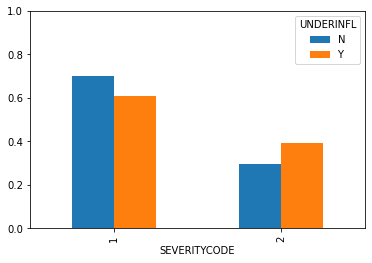

In [51]:
pd.crosstab(y, df_clean['UNDERINFL'], normalize='columns').plot.bar()
plt.ylim(0, 1)

In [52]:
pd.crosstab(y, df_clean['HITPARKEDCAR'], normalize='columns')

HITPARKEDCAR,N,Y
SEVERITYCODE,,
1,0.689186,0.936331
2,0.310814,0.063669


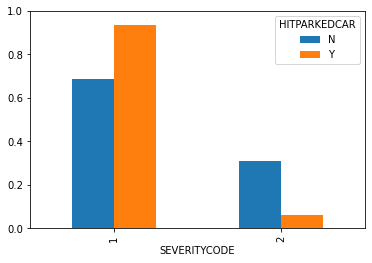

In [53]:
pd.crosstab(y, df_clean['HITPARKEDCAR'], normalize='columns').plot.bar()
plt.ylim(0, 1)
plt.show()

In [54]:
pd.crosstab(y, df_clean['WEATHER'], normalize='columns')

WEATHER,Clear,Other,Overcast,Raining,Snowing
SEVERITYCODE,,,,,
1,0.709392,0.773237,0.682746,0.660659,0.812081
2,0.290608,0.226763,0.317254,0.339341,0.187919


(0.0, 1.0)

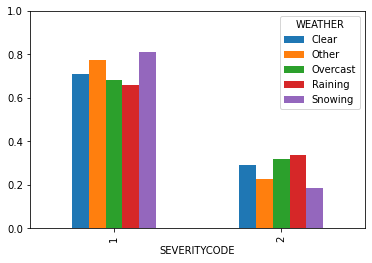

In [55]:
pd.crosstab(y, df_clean['WEATHER'], normalize='columns').plot.bar()
plt.ylim(0, 1)

In [56]:
pd.crosstab(y, df_clean['ROADCOND'], normalize='columns')

ROADCOND,Dry,Ice,Other,Snow/Slush,Wet
SEVERITYCODE,,,,,
1,0.707302,0.774002,0.681548,0.832154,0.666225
2,0.292698,0.225998,0.318452,0.167846,0.333775


(0.0, 1.0)

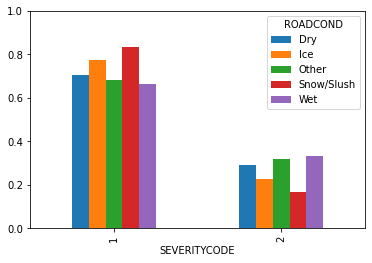

In [57]:
pd.crosstab(y, df_clean['ROADCOND'], normalize='columns').plot.bar()
plt.ylim(0, 1)

In [58]:
pd.crosstab(y, df_clean['LIGHTCOND'], normalize='columns')

LIGHTCOND,Dark - No Street Lights,Dark - Street Lights Off,Dark - Street Lights On,Dawn,Daylight,Dusk,Other
SEVERITYCODE,,,,,,,
1,0.780152,0.734375,0.700046,0.665566,0.698281,0.668052,0.79397
2,0.219848,0.265625,0.299954,0.334434,0.301719,0.331948,0.20603


(0.0, 1.0)

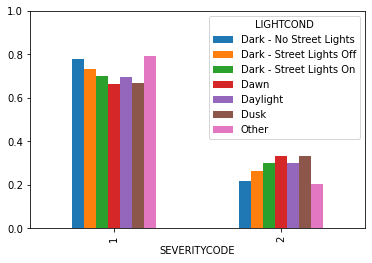

In [59]:
pd.crosstab(y, df_clean['LIGHTCOND'], normalize='columns').plot.bar()
plt.ylim(0, 1)

We will also visualize severe accidents from 2019 in a heatmap

In [60]:
# Get the latitude and longitude values for the city of Seattle
g = geocoder.osm('Seattle, WA')
s_lat, s_lng = g.latlng
s_lat, s_lng

(47.6038321, -122.3300624)

In [61]:
# create base map
heatmap = folium.Map(location=[s_lat, s_lng],
                     zoomSnap=0.25,
                     zoom_start=11)

df_severe = df_clean[df_clean['SEVERITYCODE'].eq(2) & df_clean['INCDTTM'].dt.year.eq(2019)]
hm = folium.plugins.HeatMap(list(zip(df_severe.Y, df_severe.X)), radius=13)
heatmap.add_child(hm)

heatmap

This can be interesting to pinpoint hotspots, places with many severe accidents, but it is not very useful for us in this project.

### Modeling

We are using a stratified split with 20% of the dataset for testing. We will use the random undersampling technique to train the models.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#### Logistic Regression Imbalanced

In [63]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)
print(classification_report(y_test, lr_yhat))

              precision    recall  f1-score   support

           1       0.76      0.96      0.84     26444
           2       0.75      0.28      0.41     11424

    accuracy                           0.75     37868
   macro avg       0.75      0.62      0.63     37868
weighted avg       0.75      0.75      0.71     37868



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


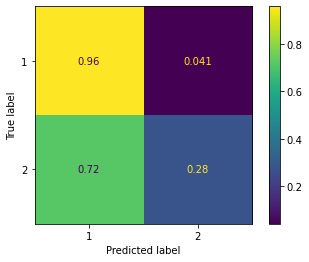

In [64]:
plot_confusion_matrix(lr, X_test, y_test, normalize='true')

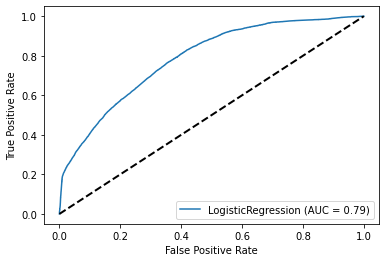

In [65]:
plot_roc_curve(lr, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

#### Logistic Regression Balanced

In [66]:
lr_bal = Pipeline([
    ('random_sampler', RandomUnderSampler(random_state=42)),
    ('std', StandardScaler()),
    ('lr', LogisticRegression(random_state=42))
])

In [67]:
lr_param = {'lr__C': [1, 10, 100, 1000, 10000]}

lr_search = GridSearchCV(lr_bal, lr_param, n_jobs=-1, cv=3)

In [68]:
lr_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('random_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('std', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1, param_grid={'lr__C': [1, 10, 100, 1000, 10000]})

In [69]:
lr_search.best_params_

{'lr__C': 1}

In [70]:
lr_bal_yhat = lr_search.predict(X_test)

In [71]:
print(classification_report(y_test, lr_bal_yhat))

              precision    recall  f1-score   support

           1       0.87      0.62      0.72     26444
           2       0.47      0.79      0.59     11424

    accuracy                           0.67     37868
   macro avg       0.67      0.70      0.66     37868
weighted avg       0.75      0.67      0.68     37868



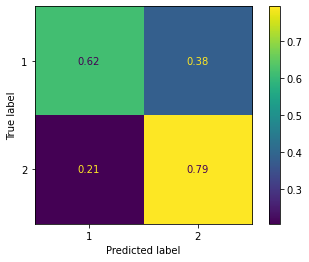

In [72]:
plot_confusion_matrix(lr_search, X_test, y_test, normalize='true')

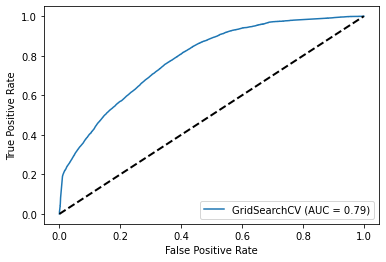

In [73]:
plot_roc_curve(lr_search, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

#### Random Forest Imbalanced

In [74]:
rf = RandomForestClassifier(random_state=42)

In [75]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [76]:
rf_yhat = rf.predict(X_test)

In [77]:
print(classification_report(y_test, rf_yhat))

              precision    recall  f1-score   support

           1       0.77      0.90      0.83     26444
           2       0.63      0.39      0.48     11424

    accuracy                           0.75     37868
   macro avg       0.70      0.65      0.66     37868
weighted avg       0.73      0.75      0.73     37868



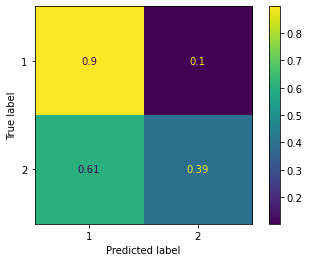

In [78]:
plot_confusion_matrix(rf, X_test, y_test, normalize='true')

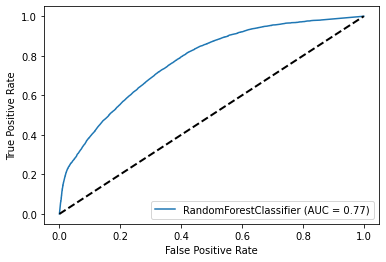

In [79]:
plot_roc_curve(rf, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

#### Random Forest Balanced

In [80]:
rf_bal = Pipeline([('random_sampler', RandomUnderSampler(random_state=42)),
                   ('std', StandardScaler()),
                   ('rf', RandomForestClassifier(random_state=42))])

In [81]:
rf_param = {'rf__max_depth': [5, 10, None],
            'rf__n_estimators': [200, 300],
            'rf__min_samples_leaf': [5, 20],
            'rf__max_features': ['auto', 'sqrt']}
rf_search = GridSearchCV(rf_bal, rf_param, cv=3, n_jobs=-1)

In [82]:
rf_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('random_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('std', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10, None],
                         'rf__max_features': ['auto', 'sqrt'],
                         'rf__min_samples_leaf': [5, 20],
                         'rf__n_estimators': [200, 300]})

In [83]:
rf_search.best_params_

{'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 5,
 'rf__n_estimators': 300}

In [85]:
rf_bal_yhat = rf_search.predict(X_test)

In [86]:
print(classification_report(y_test, rf_bal_yhat))

              precision    recall  f1-score   support

           1       0.88      0.64      0.74     26444
           2       0.49      0.80      0.61     11424

    accuracy                           0.69     37868
   macro avg       0.69      0.72      0.67     37868
weighted avg       0.76      0.69      0.70     37868



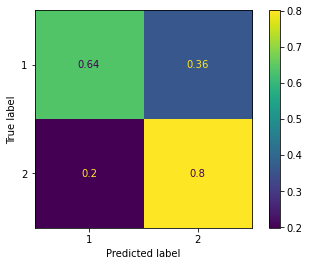

In [87]:
plot_confusion_matrix(rf_search, X_test, y_test, normalize='true')

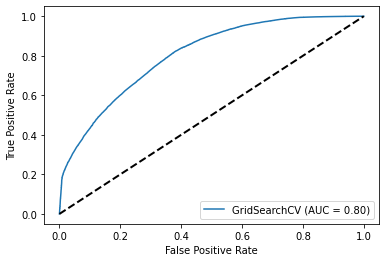

In [88]:
plot_roc_curve(rf_search, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

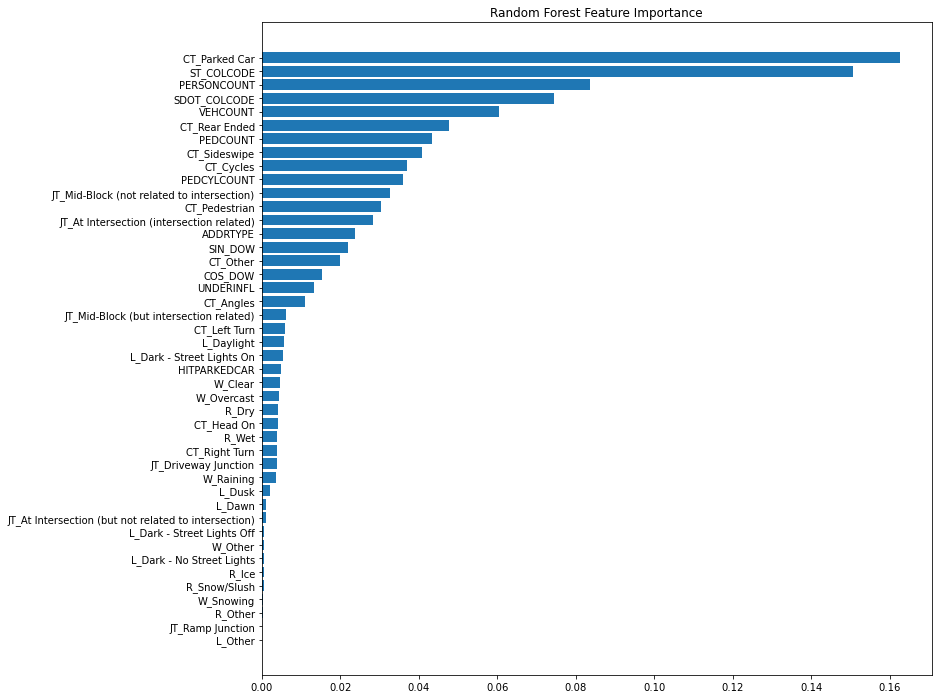

In [111]:
sorted_idx = rf_search.best_estimator_.steps[-1][-1].feature_importances_.argsort()
plt.figure(figsize=(12, 12))
plt.barh(X.columns[sorted_idx], rf_search.best_estimator_.steps[-1][-1].feature_importances_[sorted_idx])
plt.title('Random Forest Feature Importance')
plt.show()

#### XGBoost Imbalanced

In [90]:
xgb = XGBClassifier(random_state=42)

In [91]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [92]:
xgb_yhat = xgb.predict(X_test)

In [93]:
print(classification_report(y_test, xgb_yhat))

              precision    recall  f1-score   support

           1       0.77      0.93      0.85     26444
           2       0.70      0.37      0.48     11424

    accuracy                           0.76     37868
   macro avg       0.74      0.65      0.66     37868
weighted avg       0.75      0.76      0.74     37868



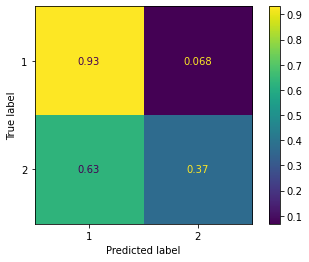

In [94]:
plot_confusion_matrix(xgb, X_test, y_test, normalize='true')

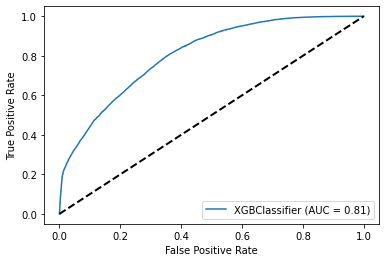

In [95]:
plot_roc_curve(xgb, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

#### XGBoost Balanced

In [96]:
xgb_bal = Pipeline([
    ('random_sampler', RandomUnderSampler(random_state=42)),
    ('std', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42))
])

In [97]:
xgb_param = {'xgb__gamma': [0.5, 1, 2],
             'xgb__max_depth': [3, 6],
             'xgb__n_estimators': [1, 100, 200]}
xgb_search = GridSearchCV(xgb_bal, xgb_param, cv=3)

In [98]:
xgb_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('random_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('std', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                              

In [100]:
xgb_search.best_params_

{'xgb__gamma': 2, 'xgb__max_depth': 6, 'xgb__n_estimators': 100}

In [101]:
xgb_bal_yhat = xgb_search.predict(X_test)

In [102]:
print(classification_report(y_test, xgb_bal_yhat))

              precision    recall  f1-score   support

           1       0.89      0.63      0.74     26444
           2       0.49      0.81      0.61     11424

    accuracy                           0.69     37868
   macro avg       0.69      0.72      0.67     37868
weighted avg       0.77      0.69      0.70     37868



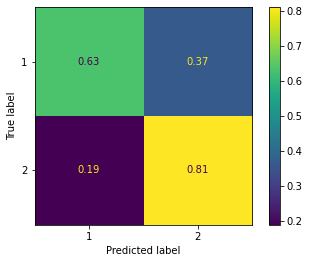

In [103]:
plot_confusion_matrix(xgb_search, X_test, y_test, normalize='true')

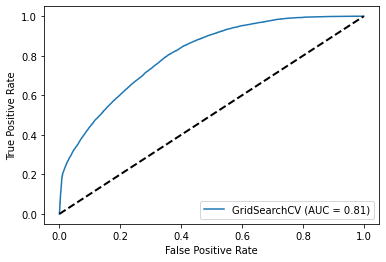

In [104]:
plot_roc_curve(xgb_search, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

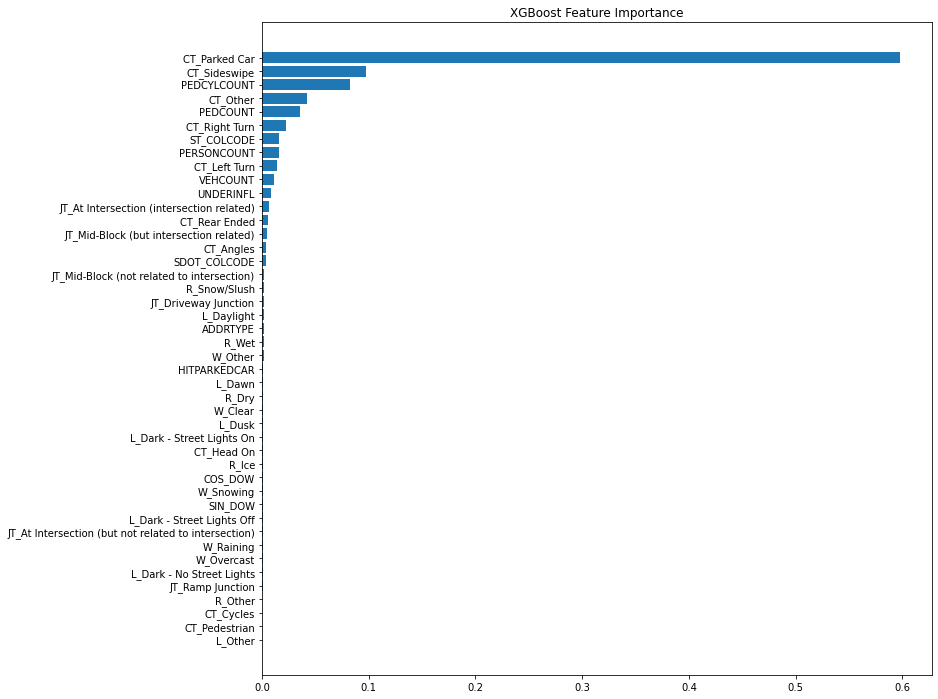

In [110]:
sorted_idx = xgb_search.best_estimator_.steps[-1][-1].feature_importances_.argsort()
plt.figure(figsize=(12, 12))
plt.barh(X.columns[sorted_idx], xgb_search.best_estimator_.steps[-1][-1].feature_importances_[sorted_idx])
plt.title('XGBoost Feature Importance')
plt.show()

In [106]:
explainer = shap.TreeExplainer(xgb_search.best_estimator_.steps[-1][-1])
shap_values = explainer.shap_values(X)

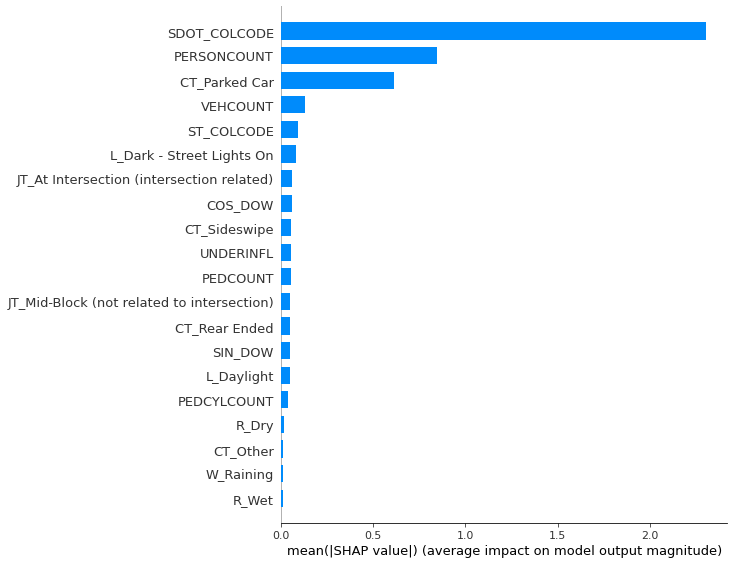

In [107]:
shap.summary_plot(shap_values, X, plot_type='bar')

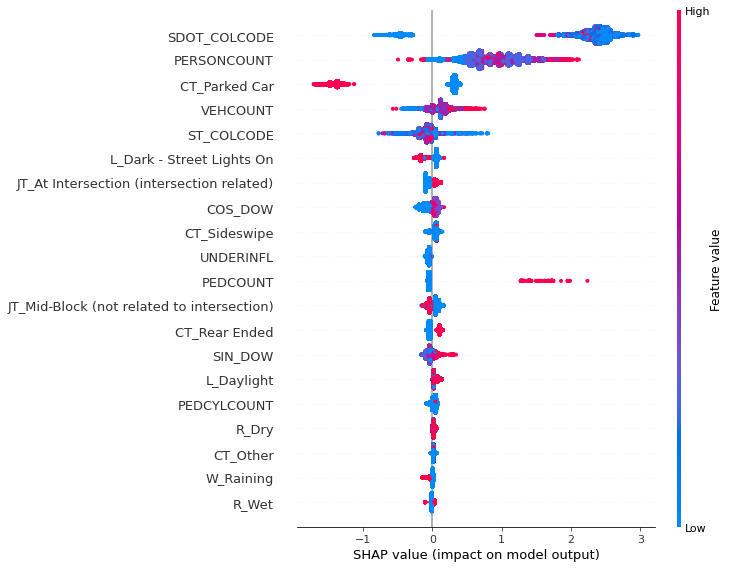

In [108]:
shap.summary_plot(shap_values, X)

## Results and Discussion <a name="results"></a>

## Conclusion <a name="conclusion"></a>